# Snakes and Sequences: Senegalese Serpent Venom Sequencing Hackathon

<font color="red">[TODO: IMAGE HERE] (note: embed all images into the notebook)</font>

Snakes pose a significant danger in Senegal, where encounters with venomous species can lead to severe injury or even death. The diversity and potency of snake venoms in the region present a major public health challenge, with traditional methods of antivenom production often falling short due to the unique and complex nature of these venoms. This is where tandem mass spectrometry combined with _de novo_ peptide sequencing could potentially play a role.

_De novo_ peptide sequencing involves determining the amino acid sequence of peptides from a mass spectrum without prior knowledge of the protein sequence, potentially making it a tool in the fight against snake bites. Unlike traditional database search methods, which rely on existing sequence databases and often fail when encountering novel or highly variable venom components, _de novo_ sequencing provides an unbiased and comprehensive analysis of venom peptides. This approach could potentially allow for the identification of new and unique venom peptides, which is crucial for the development of effective and specific antivenoms.

By leveraging mass spectrometry with _de novo_ peptide sequencing, researchers could potentially create tailored antivenoms that are more effective against the diverse snake venom profiles found in Senegal. If successful, This may have the potential not only to improve the chances of survival for snakebite victims but also to enhance the overall public health response to snakebite emergencies. We believe that the ability to rapidly and accurately sequence venom peptides could represent a significant advancement in our efforts to combat the dangers posed by snakes in Senegal and beyond.

## The Task: recalibrating model predictions

How can we help? In this hackathon we will be improving existing _de novo_ peptide sequencing models. Specifically, we will be looking into recalibration and filtering! Rather than training a large _de novo_ sequencing model from scratch, we will focus on using various techniques to improve the area under the curve (AUC) for the precision-recall graph. Due to high noise, our models are often not super well calibrated.

InstaDeep has developed a transformer-based _de novo_ peptide sequencing model **InstaNovo** [[preprint](https://www.biorxiv.org/content/10.1101/2023.08.30.555055v3)][[code](https://github.com/instadeepai/InstaNovo)]. 
We will provide you with the inputs AND outputs of InstaNovo along with some additional metadata (eg. retention time). The InstaNovo outputs include the top 5 beam predictions along with their model confidences.
Your task is to use these inputs and metadata to re-calibrate the confidence measurements and filter out any false positives in order to maximise the AUC!

<font color="red">[TODO: INSTANOVO HERE]</font>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# Introduction to Mass Spectrometry for _De Novo_ Peptide Sequencing
Mass spectrometry (MS) is an analytical technique used to measure the mass-to-charge ratio (m/z) of ions. It is widely used in proteomics, especially for _de novo_ sequencing, where the goal is to determine the amino acid sequence of a peptide directly from the mass spectrometric data without prior knowledge of the sequence.

## Process Overview:
- **Ionization:** The peptide sample is ionized, usually by electrospray ionization (ESI) or matrix-assisted laser desorption/ionization (MALDI), generating charged peptide ions.

- **Mass Analysis (MS1):** The ionized peptides are first separated based on their m/z ratios. The resulting spectrum (MS1) shows the m/z values of the precursor ions (the intact peptides).

- **Fragmentation:** Selected precursor ions are further fragmented into smaller ions. This fragmentation process is critical for _de novo_ sequencing as it generates the ion fragments needed to determine the peptide sequence.

- **Mass Analysis (MS2):** The fragments are analyzed to produce an MS2 spectrum, where the mz_array represents the m/z values of the fragment ions and the intensity_array reflects their abundance.

- **_De Novo_ Sequencing:** The MS2 data (mz_array and intensity_array) are used to infer the peptide sequence. By analyzing the differences between the m/z values, the sequence of the peptide can be reconstructed.

<font color="red">[TODO: MS OVERVIEW DIAGRAM HERE]</font>

## _De novo_ sequencing hand example

<font color="red">[TODO] Give example here, include explanation of amino acids and their masses</font>

In [28]:
train_df = pd.read_csv("data/Train.csv", na_filter="")
test_df = pd.read_csv("data/Test.csv", na_filter="")
train_df.head(3)

,ID,exp_id,precursor_mz,precursor_mass,precursor_charge,retention_time,mz_array,intensity_array,preds_beam_0,log_probs_beam_0,preds_beam_1,log_probs_beam_1,preds_beam_2,log_probs_beam_2,preds_beam_3,log_probs_beam_3,preds_beam_4,log_probs_beam_4,target
0,ID_2ohusw,EXP_two56w,629.314941,629.314941,2,11.883,[ 104.27165222 110.06439209 110.07133484 11...,[ 5718.949 6286.8384 74191.05 640...,TFAHTESHLSK,-0.024192,TFAHTESHLSK,-3.836732,LFLASSEGGFTK,-17.384193,NFLASSEGGFTK,-18.967207,LFLASSEGGFTK,-20.012611,TFAHTESHLSK
1,ID_kkx9xc,EXP_8pj4j3,419.878815,419.878815,3,13.594,[ 101.07060242 102.05498505 107.53672791 10...,[ 23240.135 14391.908 4535.9688 4619.13...,TFAHTESHLSK,-1.219249,TFAHTESHLSK,-2.084758,MLHSGNKVEDK,-11.036731,GLGQGSNKVEDK,-18.822683,VGQASGNKVEDK,-20.995831,TFAHTESHLSK
2,ID_vbx3bu,EXP_xrjdxh,527.278381,527.278381,3,16.418,[ 101.07051086 101.10723114 102.05454254 11...,[ 15584.973 4115.275 12363.395 32727...,YKPETQHELAVHK,-0.553875,YKPETQHELAVHK,-5.546686,KYPETQHELAVHK,-6.195591,YKPETQHELAVHK,-16.678877,YKPETQHELAVHK,-16.705442,YKPETQHELAVHK


## Exploring mass-spectrometry data

**To perform _de novo_ sequencing, we require both MS1 and MS2 information:**
- From MS1:
  - `precursor_mass` - The mass of the full peptide
  - `precursor_mz` - The mass-to-charge of the full peptide
  - `precursor_charge` - The charge of the peptide
- From MS2:
  - `mz_array` - The mass-to-charge value of each peak (x-axis)
  - `intensity_array` - The abundance of each peak (y-axis)

**Additional information:**
- `retention_time` - The time (in minutes) it took for the peptide to elute from the HPLC
- `exp_id` - The ID of the experiment, may be used to normalise retention time across experiments

**Model outputs:**
- `preds_beam_0` - The most confident predicted peptide
- `log_probs_beam_0` - The log-probability under the model for the predicted peptide
- `preds_beam_1-4` - The other beam outputs in decreasing order of confidence
- `preds_beam_1-4` - The log-probability of the beam outputs in decreasing order of confidence

### Quick data cleaning

This code is used to convert the String format of the mz and intensity arrays into a list of floats

_This is caused by saving lists of floats in csv files_

In [37]:
train_df["mz_array"] = train_df["mz_array"].map(lambda x: list(map(float, re.findall(r'\d+\.\d*', x))) if isinstance(x, str) else x)
train_df["intensity_array"] = train_df["intensity_array"].map(lambda x: list(map(float, re.findall(r'\d+\.\d*', x))) if isinstance(x, str) else x)
test_df["mz_array"] = train_df["mz_array"].map(lambda x: list(map(float, re.findall(r'\d+\.\d+', x))) if isinstance(x, str) else x)
test_df["intensity_array"] = train_df["intensity_array"].map(lambda x: list(map(float, re.findall(r'\d+\.\d*', x))) if isinstance(x, str) else x)

### Plotting a MS2 spectrum

We can plot the MS2 spectrum as follows

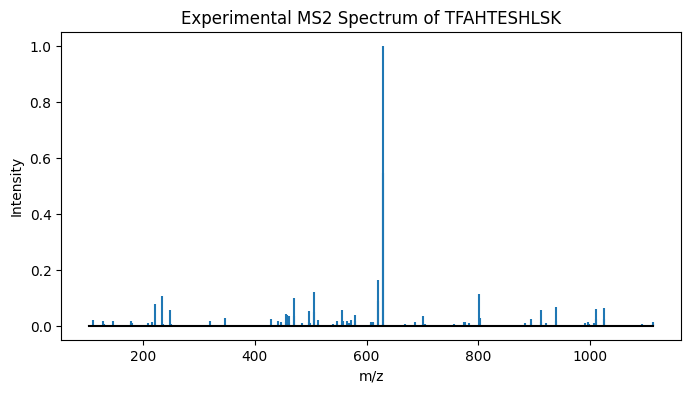

In [56]:
row = train_df.iloc[0]

plt.figure(figsize=(8, 4))
plt.stem(row['mz_array'], row['intensity_array']/np.max(row['intensity_array']), markerfmt="", basefmt='black')
plt.xlabel('m/z')
plt.ylabel('Intensity')
plt.title(f'Experimental MS2 Spectrum of {row["target"]}')
plt.show()

### Comparison to a theoretical spectrum

Earlier we mentioned [TODO] that all amino acids have a fixed mass. We can use this to calculate the theoretical spectrum of a given peptide! Let's do this for the predicted peptide.

First, we will define some helper functions to calculate the mass of a sequence

In [51]:
# Amino acid masses
residue_masses = {
    "G": 57.021464,
    "A": 71.037114,
    "S": 87.032028,
    "P": 97.052764,
    "V": 99.068414,
    "T": 101.047670,
    "C": 103.009185,
    "L": 113.084064,
    "I": 113.084064,
    "N": 114.042927,
    "D": 115.026943,
    "Q": 128.058578,
    "K": 128.094963,
    "E": 129.042593,
    "M": 131.040485,
    "H": 137.058912,
    "F": 147.068414,
    "R": 156.101111,
    "Y": 163.063329,
    "W": 186.079313,
    # Modifications
    "M(+15.99)": 147.035400, # Oxidation
    "C(+57.02)": 160.030649, # Cysteine alkylation
    "N(+.98)": 115.026943, # Deamidation
    "Q(+.98)": 129.042594, # Deamidation
    # Phospho modifications
    "S(+79.97)": 166.998028, # Phosphorylation + 79.966
    "T(+79.97)": 181.01367, # Phosphorylation + 79.966
    "Y(+79.97)": 243.029329, # Phosphorylation + 79.966
}

tokenizer_regex = r"(\([^)]+\))|([A-Z](?:\([^)]+\))?)"

PROTON_MASS_AMU = 1.007276
H2O_MASS = 18.0106

def tokenize(sequence: str) -> list[str]:
    """Split a peptide represented as a string into a list of residues.

    Args:
        sequence (str): The peptide to be split.

    Returns:
        list[str]: The sequence of residues forming the peptide.
    """
    return [
        item for sublist in re.findall(tokenizer_regex, sequence)
        for item in sublist if item
    ]

def get_sequence_mass(sequence: list[str], charge: int | None) -> float:
    """Get the mass of a sequence.

    Args:
        sequence (list[str]):
            The residue sequence whose mass to calculate.
            All residues must be in the residue set or
            this will raise a `KeyError`.
        charge (int | None, optional):
            Charge of the sequence to calculate the mass.

    Returns:
        float: The mass of the sequence in Daltons.
    """
    mass = sum([residue_masses[residue] for residue in sequence]) + H2O_MASS
    if charge:
        mass = (mass / charge) + PROTON_MASS_AMU
    return float(mass)

To find the theoretical spectra, we need to compute the masses of all combinations of the peptide

In [58]:
sequence = row['preds_beam_0']
substrings = [sequence[:i+1] for i in range(len(sequence))][:-1]
reverse_substrings = [sequence[i:] for i in range(len(sequence))][1:]
print("        Substrings: " + ", ".join(substrings))
print("Reverse substrings: " + ", ".join(reverse_substrings[::-1]))

        Substrings: T, TF, TFA, TFAH, TFAHT, TFAHTE, TFAHTES, TFAHTESH, TFAHTESHL, TFAHTESHLS
Reverse substrings: K, SK, LSK, HLSK, SHLSK, ESHLSK, TESHLSK, HTESHLSK, AHTESHLSK, FAHTESHLSK


In [60]:
b_ions = [get_sequence_mass(x, charge=1) for x in substrings]
y_ions = [get_sequence_mass(x, charge=1) for x in reverse_substrings]

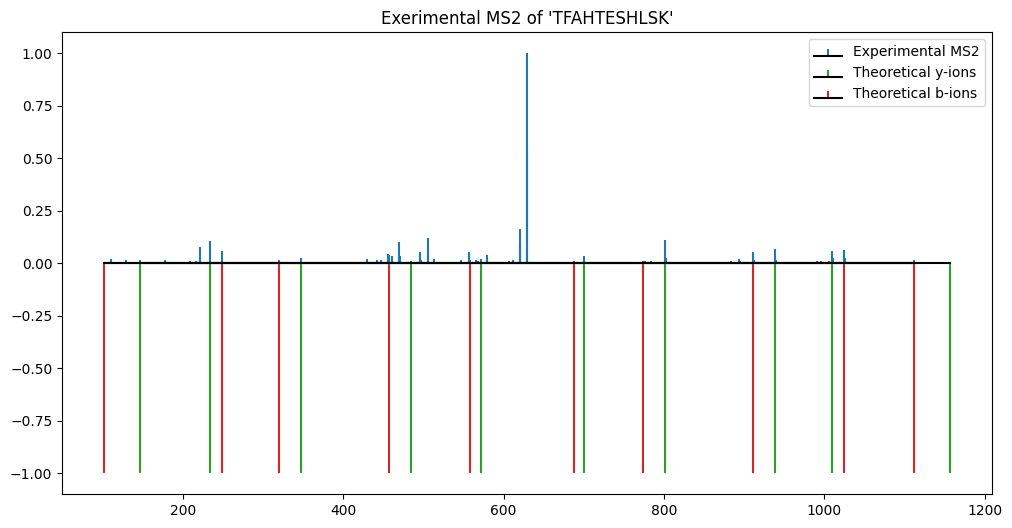

In [66]:
plt.figure(figsize=(12,6))

plt.stem(row['mz_array'], row['intensity_array']/np.max(row['intensity_array']), markerfmt="", basefmt='black')
plt.stem(np.array(y_ions), -np.ones(len(y_ions)), markerfmt='', linefmt='tab:green', basefmt='black')
plt.stem(np.array(b_ions) - H2O_MASS, -np.ones(len(b_ions)), markerfmt='', linefmt='tab:red', basefmt='black')
plt.legend(["Experimental MS2", "Theoretical y-ions", "Theoretical b-ions"])
plt.title(f"Exerimental MS2 of '{row['target']}'")
plt.show()

As you can see, the peaks actually line up quite well with the theoretical spectra! The large experimental peak in the middle that doesn't have a corresponding theoretical peak is caused by the MS1 precursor and is generally removed before running InstaNovo.

**Hint: If we are able to compare the theoretical spectra to our experimental spectra, perhaps we could use this for filtering? If we predict the wrong peptide, it probably won't look similar to the experimental spectra! Could we do the same for Retention Time?**



### Improved theoretical spectrum with Prosit

[TODO]

## Calculating AUC and improving the curve

Below we have included some code to help calculate AUC and plot the precision recall curve

In [82]:
def calculate_auc(targets, preds, log_probs, label=None, plot=True, xlim=0.7):
    conf = np.exp(log_probs)
    order = conf.argsort()[::-1]
    matches = np.array(targets == preds)
    matches = matches[order]
    conf = conf[order]
    
    csum = np.cumsum(matches)
    precision = csum / (np.arange(len(matches)) + 1)
    recall = csum / len(matches)

    # Calculate AUC
    width = recall[1:] - recall[:-1]
    height = np.minimum(precision[1:], precision[:-1])
    top = np.maximum(precision[1:], precision[:-1])
    side = top - height
    auc = (width * height).sum() + 0.5 * (side * width).sum()
    
    # Plot 
    if plot:
        if label:
            plt.plot(recall, precision, label=f"{label} (AUC = {auc:.3f})")
        else:
            plt.plot(recall, precision, label=f"AUC = {auc:.3f}")
        plt.xlim(0,xlim)
        plt.ylim(0,1)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.legend()
        plt.grid(True)

    return auc

AUC: 0.644943



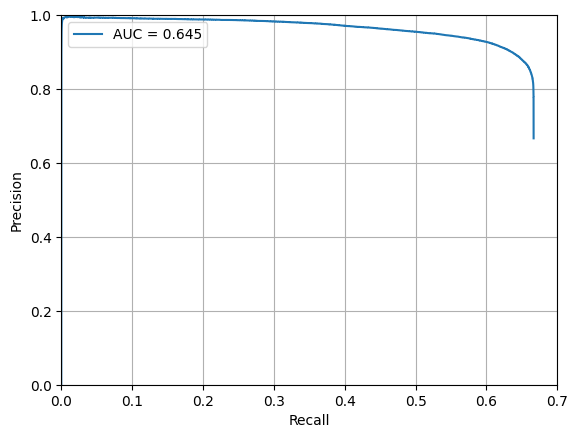

In [83]:
auc = calculate_auc(train_df["target"], train_df["preds_beam_0"], train_df["log_probs_beam_0"])
print(f"AUC: {auc:.6f}\n")

The precision-recall curve looks pretty good for `train_df`!

_Note: `train_df` is actually a calibration set and our model has never seen these peptides!_

We can calculate the AUC plot the precision-recall curve for all five beams. As one might expect, the one with the highest log-probabilities (beam 0) does the best!

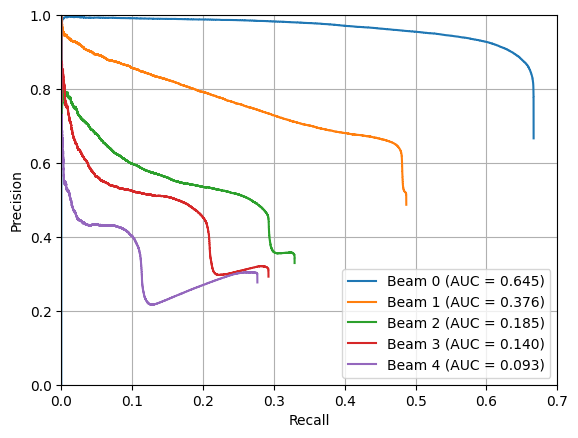

In [84]:
for beam in range(5):
    auc = calculate_auc(train_df["target"], train_df[f"preds_beam_{beam}"], train_df[f"log_probs_beam_{beam}"], label=f"Beam {beam}")

As one might expect, the performance gets significantly worse as we try the other beams but there may still be some useful information in them, especially the rank 2 beams (`beam_preds_1`). Perhaps there is some way to select the rank 2 beam if we know the rank 1 beam is incorrect?

**Hint: try comparing the theoretical mass of the predicted sequence to the precursor mass!**

## Filtering on precursor mass

Here is a function that can be used to check whether a sequence matches the precursor to some PPM tolerance

In [85]:
max_isotope_error = 1 # We have to consider isotopes! We will consider 0 to 1, but try using more!

CARBON_MASS_DELTA = 1.00335

def _calc_mass_error(
    mz_theoretical: float, mz_measured: float, charge: int, isotope: int = 0
) -> float:
    """Calculate the mass error between theoretical and actual mz in ppm."""
    return float(
        (mz_theoretical - (mz_measured - isotope * CARBON_MASS_DELTA / charge))
        / mz_measured
        * 10**6
    )

def _mass(seq: str | list[str], charge: int | None = None) -> float:
    """Calculate a peptide's mass or m/z."""
    if isinstance(seq, str):
        seq = tokenize(seq)
    return get_sequence_mass(seq, charge)

def matches_precursor(
    seq: str | list[str],
    prec_mass: float,
    prec_charge: int,
    prec_tol: int = 50,
) -> tuple[bool, list[float]]:
    """Check if a sequence matches the precursor mass within some tolerance."""
    seq_mass = _mass(seq, charge=prec_charge)
    delta_mass_ppm = [
        _calc_mass_error(seq_mass, prec_mass, prec_charge, isotope)
        for isotope in range(0, max_isotope_error + 1)
    ]
    return any(abs(d) < prec_tol for d in delta_mass_ppm), delta_mass_ppm

We can use this to try and filter our predictions to a tighter tolerance of 20ppm!

In [97]:
train_df_filtered = train_df.copy()
precursor_match = np.array([
    matches_precursor(
        row["preds_beam_0"], 
        row["precursor_mz"], 
        row["precursor_charge"], 
        prec_tol=10
    )[0] if len(row["preds_beam_0"])>0 else False 
    for _,row in train_df_filtered.iterrows()
])

In [98]:
# Set the predictions to empty strings and log probabilities to -inf
train_df_filtered.loc[~precursor_match, "preds_beam_0"] = ""
train_df_filtered.loc[~precursor_match, "log_probs_beam_0"] = -np.inf

Original AUC: 0.644943

Filtered AUC: 0.645299



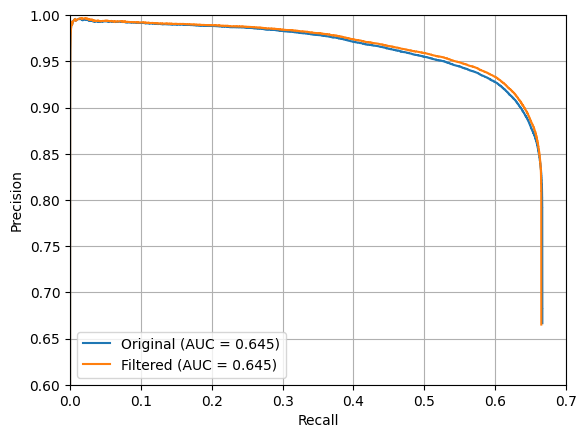

In [100]:
auc = calculate_auc(train_df["target"], train_df["preds_beam_0"], train_df["log_probs_beam_0"], label="Original")
print(f"Original AUC: {auc:.6f}\n")
auc = calculate_auc(train_df_filtered["target"], train_df_filtered["preds_beam_0"], train_df_filtered["log_probs_beam_0"], label="Filtered")
print(f"Filtered AUC: {auc:.6f}\n")
plt.ylim([0.6,1.0]);

Very small improvement but it works. This is just a proof-of-concept, you should try some other techniques!

## Creating a submission file

Since we now know beam 0 is the best, let's try create a submission file to get a baseline AUC score on the test set!

In [10]:
test_df.head(3)

,ID,exp_id,precursor_mz,precursor_mass,precursor_charge,retention_time,mz_array,intensity_array,preds_beam_0,log_probs_beam_0,preds_beam_1,log_probs_beam_1,preds_beam_2,log_probs_beam_2,preds_beam_3,log_probs_beam_3,preds_beam_4,log_probs_beam_4
0,ID_6ij0wu,EXP_yu8x32,587.81171,1174.61614,2,41.8792,[ 120.08066 121.083954 129.102 130.0860...,[ 26172.395 2888.4343 44922.97 48788.57...,VSEELEDLLK,-0.322313,VSEELEDLLK,-1.929051,VSEELEDLLK,-2.653483,VSEELEDLLK,-3.966449,VSQ(+.98)ELEDLLK,-4.217722
1,ID_lzos7i,EXP_yu8x32,629.63892,1886.90219,3,20.8736,[ 148.5065 148.5076 148.50868 148.50977 ...,[0.00000000e+00 0.00000000e+00 0.00000000e+00 ...,NPEETPRPLS(+79.97)PVQNTK,-23.293793,LPEETPRPLS(+79.97)PVQNTK,-23.770130,LPEETPRPLS(+79.97)PVQNTK,-24.996239,APEETPRPLS(+79.97)PVQNTK,-28.089029,APEETPRPLS(+79.97)PVQNTK,-28.089029
2,ID_2jrjcu,EXP_yu8x32,638.29059,1275.57390,2,23.5429,[ 120.08056 122.071335 129.06589 129.1020...,[ 8050.1357 2847.9668 1811.2905 20487.65...,THLMSESEWR,-0.075819,THLMSETDWR,-2.886961,THLMSESEWR,-5.700818,THLMSETDWR,-6.222891,SHLMSETEWR,-18.293968


In our submission file, we expect you to submit the predicted peptide along with the model confidence.

_NOTE: Model confidence is not log probabilities! Use `np.exp()`!_

In [11]:
sub_df = test_df[["ID"]].copy()
sub_df["target"] = test_df["preds_beam_0"]
sub_df["confidence"] = np.exp(test_df["log_probs_beam_0"])
sub_df.head()

,ID,target,confidence
0,ID_6ij0wu,VSEELEDLLK,7.244711e-01
1,ID_lzos7i,NPEETPRPLS(+79.97)PVQNTK,7.649523e-11
2,ID_2jrjcu,THLMSESEWR,9.269841e-01
3,ID_n3p24j,VNLFLLGK,4.440058e-01
4,ID_5xq54g,S(+79.97)GVLLVQAHSHVR,3.110454e-07


Save to a csv file for uploading to Zindi:

In [12]:
sub_df.to_csv("SampleSumbission.csv", index=False)